In [1]:
import torch
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

plt.style.use('fivethirtyeight')

In [2]:
## loading the data
ROOT_DIR = 'MNIST'
train_data = datasets.MNIST(
    root=ROOT_DIR,
    train=True,
    transform=transforms.ToTensor(),
    target_transform=None,
    download=True
)

test_data = datasets.MNIST(
    root=ROOT_DIR,
    train=False,
    transform=transforms.ToTensor(),
    target_transform=None,
    download=True
)

In [3]:
train_data.data.dtype

torch.uint8

In [4]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [5]:
train_data.targets.dtype

torch.int64

In [6]:
train_data.data[0].shape

torch.Size([28, 28])

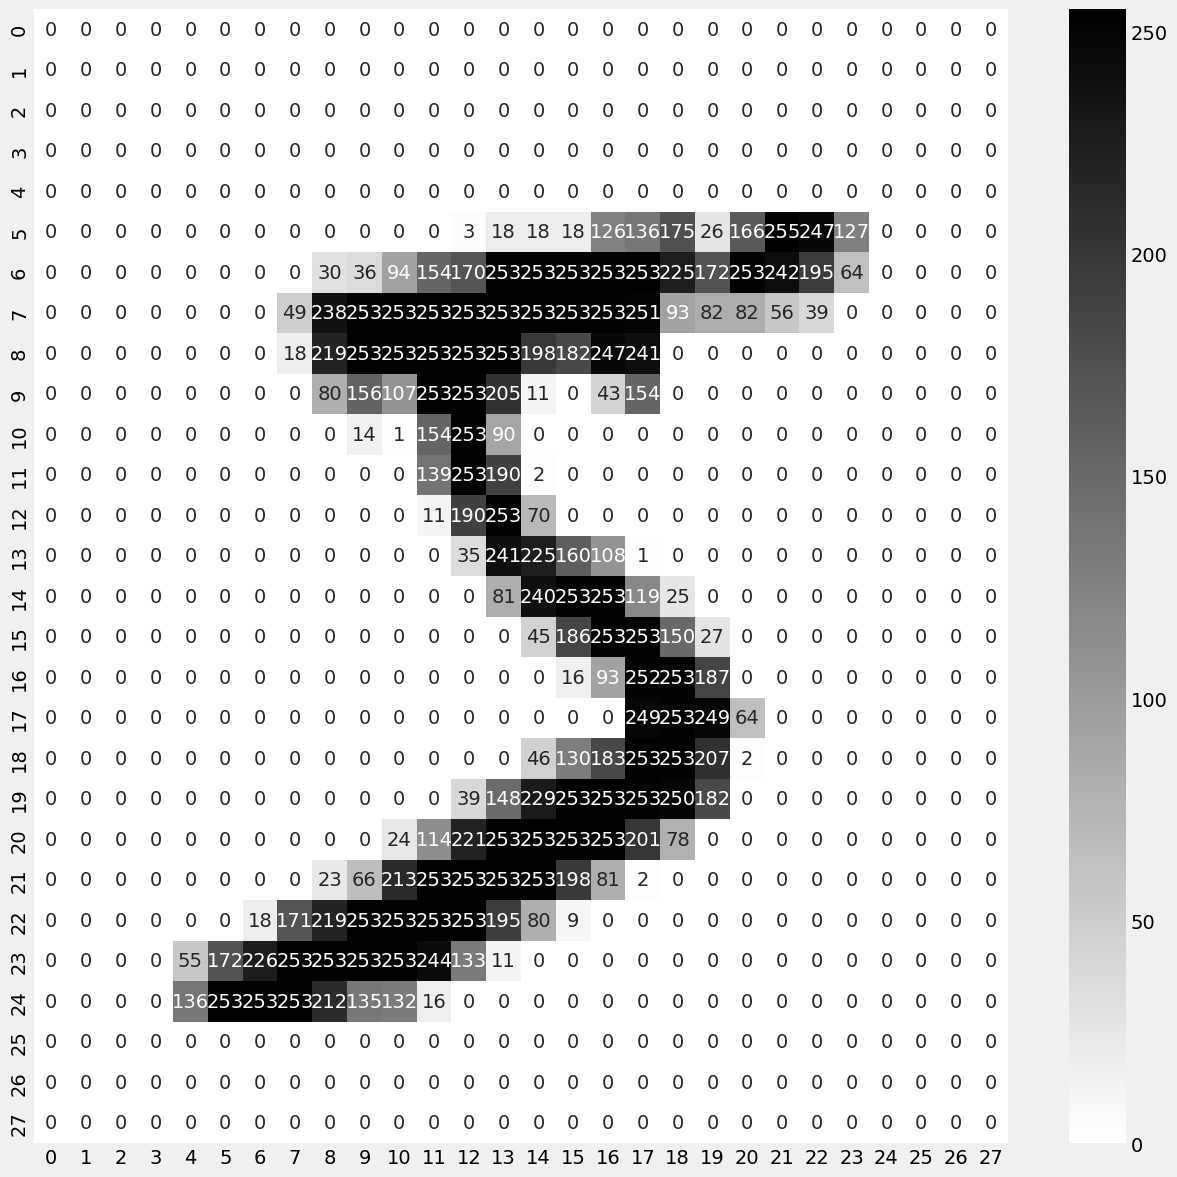

In [7]:
plt.figure(figsize=(14,14))
sns.heatmap(train_data.data[0], annot=True,cmap="binary", fmt='d')
plt.show()

In [8]:
train_data.data[0].min().numpy(), train_data.data[0].max().numpy()

(array(0, dtype=uint8), array(255, dtype=uint8))

In [9]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [10]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [11]:
train_data.targets.shape

torch.Size([60000])

In [12]:
test_data.targets.shape

torch.Size([10000])

In [13]:
BATCH = 128

train_data_loader = DataLoader(dataset=train_data,
                               batch_size=BATCH,
                               shuffle=True)

test_data_loader = DataLoader(dataset=test_data,
                              batch_size=BATCH)

In [14]:
for x in test_data_loader:
    print(x[0].shape)
    break

torch.Size([128, 1, 28, 28])


In [15]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [16]:
# Let's define the model
class NeuralNetwork(nn.Module):
    def __init__(self, in_, out_):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, out_)
        )

    def forward(self, x):
        return self.layers(x)



In [17]:
model = NeuralNetwork(784, 10)

model.to(DEVICE)
model

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [19]:
# Training loop
EPOCHS = 10
loss_ = list()
acc_ = list()

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch+1}/{EPOCHS}")
    for batch, data in enumerate(train_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)

        optimizer.zero_grad()

        y_pred = model(x.reshape(-1, 784))
        loss = loss_fn(y_pred, y)
        loss_.append(loss.item())
        loss.backward()
        optimizer.step()

        accuracy = torch.mean((torch.argmax(y_pred, 1) == y).float()).item()
        acc_.append(accuracy)

        if batch%100 == 0:
            print(f"    Batch: {batch}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

Epoch: 1/10
    Batch: 0, Loss: 2.3102, Accuracy: 0.0781
    Batch: 100, Loss: 0.3209, Accuracy: 0.9141
    Batch: 200, Loss: 0.3067, Accuracy: 0.9141
    Batch: 300, Loss: 0.2285, Accuracy: 0.9141
    Batch: 400, Loss: 0.2338, Accuracy: 0.9297
Epoch: 2/10
    Batch: 0, Loss: 0.1017, Accuracy: 0.9766
    Batch: 100, Loss: 0.1852, Accuracy: 0.9375
    Batch: 200, Loss: 0.1970, Accuracy: 0.9375
    Batch: 300, Loss: 0.1539, Accuracy: 0.9453
    Batch: 400, Loss: 0.1473, Accuracy: 0.9531
Epoch: 3/10
    Batch: 0, Loss: 0.0619, Accuracy: 0.9766
    Batch: 100, Loss: 0.1474, Accuracy: 0.9531
    Batch: 200, Loss: 0.0710, Accuracy: 0.9844
    Batch: 300, Loss: 0.0605, Accuracy: 0.9844
    Batch: 400, Loss: 0.1251, Accuracy: 0.9688
Epoch: 4/10
    Batch: 0, Loss: 0.0496, Accuracy: 0.9766
    Batch: 100, Loss: 0.0223, Accuracy: 1.0000
    Batch: 200, Loss: 0.0659, Accuracy: 0.9688
    Batch: 300, Loss: 0.1918, Accuracy: 0.9531
    Batch: 400, Loss: 0.0537, Accuracy: 0.9844
Epoch: 5/10
    Batc

<Figure size 1000x1000 with 0 Axes>

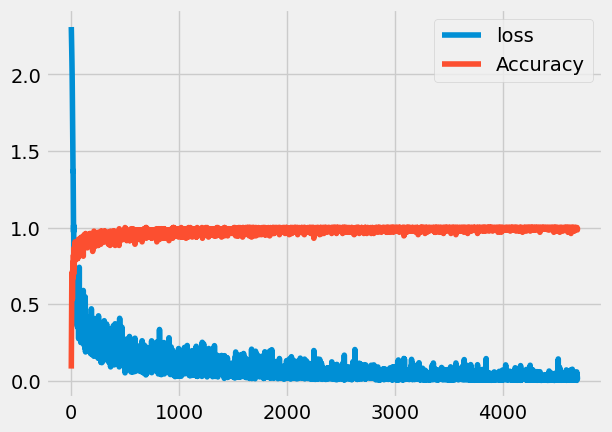

In [20]:
# plot the trinaing acc and loss
plt.figure(figsize=(10,10))
pd.DataFrame(data={'loss': loss_, "Accuracy": acc_}).plot()
plt.show()

In [22]:
# Testing over the test data
test_loss = 0
test_acc = 0

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)

        y_pred = model(x.reshape(-1, 784))

        loss = loss_fn(y_pred, y)
        test_loss += loss.item()

        test_acc += torch.mean((torch.argmax(y_pred, 1) == y).float()).item()
        batch += 1

In [25]:
print(f"Test loss: {test_loss/batch:.4f}, test accuracy: {test_acc/batch:.4f}")

Test loss: 0.0765, test accuracy: 0.9790


In [26]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)

        y_pred = model(x.reshape(-1, 784))

        loss = loss_fn(y_pred, y)

        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target, y.cpu().numpy()))

In [27]:
cm = confusion_matrix(target, pred)

<Axes: >

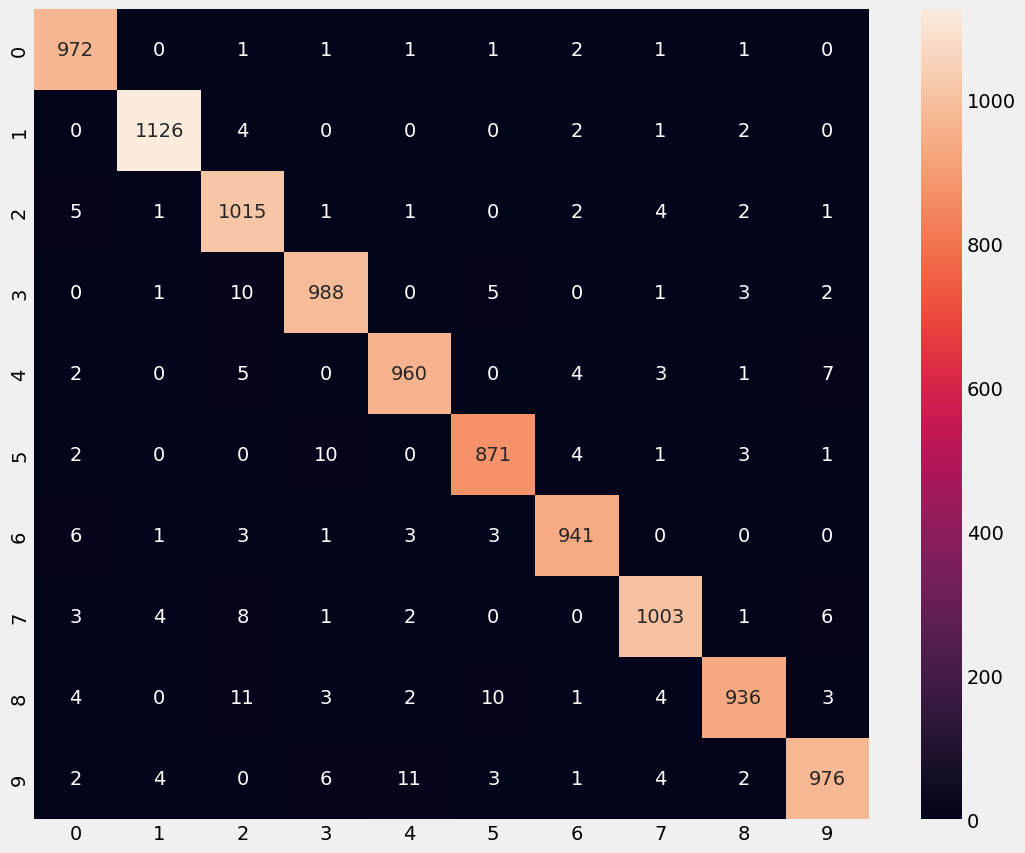

In [29]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d')